In [8]:
import pickle as pkl
import numpy as np
import os

In [18]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

##############################################
###### Funcitons #############################
##############################################

def model(n, t, lambda_t, mu):
    """
    Differential equation for the M(t)/M/1 queue:
    dn/dt = lambda(t) - mu * (1 - p0(t))
    where p0(t) is the probability of 0 customers in the system.

    For approximation, we use the relation p0 ≈ max(0, 1 - n) when n < 1
    and p0 ≈ 0 when n ≥ 1.
    """
    # Current arrival rate based on time
    current_lambda = piecewise_lambda(t, lambda_t)

    # Approximate p0
    if n < 1:
        p0 = max(0, 1 - n)
    else:
        p0 = 0

    dndt = current_lambda - mu * (1 - p0)
    return dndt

def piecewise_lambda(t, lambda_t):
    """
    Returns the arrival rate at time t based on piecewise constant definition.
    lambda_t is a list of tuples (start_time, end_time, rate)
    """
    for (start, end, rate) in lambda_t:
        if start <= t < end:
            return rate
    return 0  # default if outside all intervals


def compute_MSE(n_true, n):
  return ((n_true - n)**2).mean().item()


def create_tuples(df_sorted):

    all_tuples =  []
    for row_ind in range(df_sorted.shape[0]):
        hour = df_sorted.loc[row_ind, 'hour']
        day = df_sorted.loc[row_ind, 'day']
        rate = df_sorted.loc[row_ind, 'rate'].item()
        tot_time = hour + 24*day
        all_tuples.append((tot_time.item(),tot_time.item()+1, rate))

    return all_tuples


def plot_results(df_res, n_true):

  # Parameters
    mu = 15.0  # service rate
    all_tuples = create_tuples(df_res)
    lambda_t = all_tuples  #[(0, 10, 5.0), (10,30,1) ,(30, 50, 0.2)]  # piecewise arrival rates
    # lambda_t_true = all_tuples_true

    # Time points
    t = np.linspace(0, 168, 1000)

    # Initial condition: empty system
    n0 = 0.0
    n = create_tuples(df_res)
    # Solve the ODE
    n = odeint(model, n0, t, args=(lambda_t, mu))
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(t, n, '-', color = 'orange', linewidth=2, label = 'Predicted')
    plt.plot(t, n_true,  linewidth=2, label = 'True', linestyle = '--')
    plt.xlabel('Time')
    plt.ylabel('Number of customers in system')
    plt.title('Queue analysis')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Expected number of demands in system')
    plt.grid(True)
    print('The MSE is: ', compute_MSE(n_true, n))
    plt.show()

In [19]:
data = pkl.load(open('../data/GP_reg.pkl', 'rb'))

In [20]:
data[10]

,Demand_id,Time_stamp,Type,day,hour,day_name
0,1,0.233906,Demand,0,0,Sunday
1,1,0.273935,Release,0,0,Sunday
2,2,0.509394,Demand,0,0,Sunday
3,3,0.527414,Demand,0,0,Sunday
4,4,0.549973,Demand,0,0,Sunday
...,...,...,...,...,...,...
4081,2041,165.367720,Release,6,21,Saturday
4082,2042,165.577194,Demand,6,21,Saturday
4083,2042,165.646780,Release,6,21,Saturday
4084,2043,165.941769,Demand,6,21,Saturday


In [21]:
n_true = pkl.load(open('../data/n_true.pkl', 'rb'))
df_res = pkl.load(open('../data/res_template.pkl', 'rb') )

df_res.head()

,hour,day,rate
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0


The MSE is:  506.04745722838595


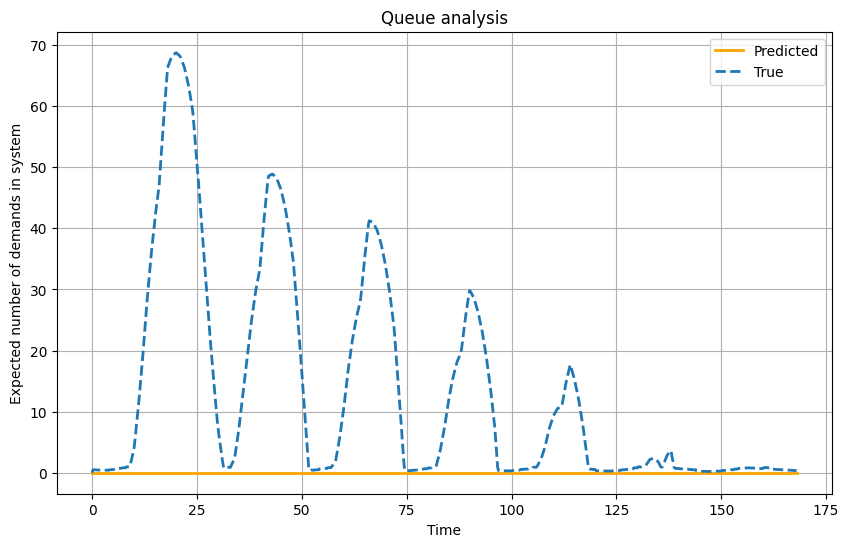

In [22]:
plot_results(df_res, n_true)